In [1]:
# !pip install torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Import Dataset

In [4]:
batch_size_1 = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
dataset_train = torchvision.datasets.MNIST(root='./data', train=True, 
                                           download=True, transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_1,
                                          shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                         transform=transform)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_1, num_workers=2,
                                         shuffle=False)

# Explore the data

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


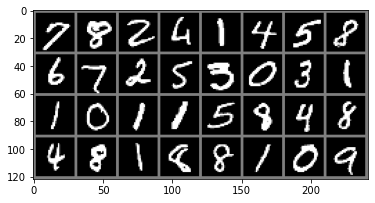

In [9]:
# function to show an image
def imshow(img):
    img = img/1.1 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
# get random training images
for images, labels in train_loader:
    imshow(torchvision.utils.make_grid(images))
    break
# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
for images, labels in train_loader:
    print("image batch size dimensions:", images.shape)
    print("image label dimensions:", labels.shape)
    break


image batch size dimensions: torch.Size([32, 1, 28, 28])
image label dimensions: torch.Size([32])


# Model

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # 28*28*1 -> 26*26*32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26*26*32, 128)
        self.d2 = nn.Linear(128,10)
        
        #define forward
    def forward(self, x):
        # 32*1*28*28 -> 32*32*26*26
        x = self.conv1(x)
        x = F.relu(x)
        
        # flatten -> 32*(32*26*26)
        x = x.flatten(start_dim=1)
        
        # 32*(32*26*26) -> 32*128
        x = self.d1(x)
        x = F.relu(x)
        
        #logits -> 32*10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [12]:
# test the model with 1 batch
model = MyModel()
for images, labels in train_loader:
    print("batch size:",images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


# Training the model

In [13]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
# compute accuracy
def get_accuracy(logit, target, batch_size):
    '''obtain accuracy for training round'''
    corrects = (torch.max(logit,1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0* corrects/batch_size
    return accuracy.item()

In [15]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    
    model = model.train()
    
    # training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #forward+backward+loss
        logits = model(images)
        loss= criterion(logits,labels)
        optimizer.zero_grad()
        loss.backward()
        
        #update model params
        optimizer.step()
        
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, batch_size_1)

        
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss /i, train_acc/i))

Epoch: 0 | Loss: 1.6971 | Train Accuracy: 76.44
Epoch: 1 | Loss: 1.5378 | Train Accuracy: 92.47
Epoch: 2 | Loss: 1.4831 | Train Accuracy: 97.98
Epoch: 3 | Loss: 1.4784 | Train Accuracy: 98.43
Epoch: 4 | Loss: 1.4760 | Train Accuracy: 98.68


In [17]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader,0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, batch_size_1)

print('Test Accuracy: %.2f'%(test_acc/i))    

Test Accuracy: 98.30
